## Import libraries

In [1]:
!pip3 install youtube-transcript-api

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
from transformers import pipeline
import pickle
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import sklearn
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import scikitplot as skplt


## Get captions from videos

In [26]:
video_list = ['8zQxifWGpyc', 'X33IC8eZHsw']
language_list = ['de', 'de']
video_trans = ""

In [27]:
for idx, video_name in enumerate(video_list):
    srt = YouTubeTranscriptApi.get_transcript(video_name, languages=[language_list[idx]])
    for i in range(len(srt)):
        s = srt[i]['text'] + ' '
        video_trans += s


## Translate captions

In [31]:
model_checkpoint = "Helsinki-NLP/opus-mt-de-en"
translator = pipeline("translation", model=model_checkpoint)


In [32]:
video_trans_split =  video_trans.split(' ')

In [33]:
n_words = len(video_trans_split)
batch_size = 200
trans_text = []
n_batches = n_words//batch_size
for i in range(n_batches):
    batch_text = ' '.join(video_trans_split[i*batch_size: (i+1)*batch_size])
    trans_text.append(translator(batch_text)[0]['translation_text'])

In [34]:
trans_text.append(translator(' '.join(video_trans_split[(n_batches * batch_size):]))[0]['translation_text'])

In [35]:
trans_text

['the name welcome to the svp offers online order can also be fully answered where you have mandat carriers and mandat carriers live place nothing current topic name and about the question answers questions was the laxe comments giga and wog connection your name is andreas rettig bp the svp Switzerland responsible communication and the foreign policy commission of the standard ecx connect where you can find interesting information with the participants that the commission of uno migrations practically diets what means that I rather reason to shout yes that is a reason to behave like simone thomalla brahms serve why there is agreement with those a commission then what it has it often long so which means fairly moderate or agree that it is very binding to us and its idol I interrupt because what is really to be harmonious in front of the switzer will then also be looking for anono migration path that would be absolutely devastating for this country you have to imagine about the dust thro

## Create context vector

In [36]:
context_vector = ' '.join(trans_text)

In [37]:
with open('topics.pickle', 'rb') as handle:
    topics_to_keyword = pickle.load(handle)

In [38]:
d = {'video_number': [1], 'context': [context_vector]}
df = pd.DataFrame(data=d)

In [39]:
classes = [set() for _ in range(len(df))]

for i, context in enumerate(df["context"]):
    for topic in topics_to_keyword:
        for keyword in topics_to_keyword[topic]:
            if keyword in context:
                classes[i].add(topic)
        

In [40]:
df['topic'] = classes

In [41]:
df

,video_number,context,topic
0,1,the name welcome to the svp offers online orde...,"{security, digitalisation, immigration, family}"


## Import df questions

In [44]:
df_questions = pd.read_csv('./csv/glarner_questions.csv', sep=';', encoding='latin-1')

In [47]:
#convert to binary
df_questions["questions"] = df_questions['questions'].str[4:-2]
df_questions.loc[df_questions['smartvote_answers'] >= 3, 'binary_smarvote_answer'] = 0
df_questions.loc[df_questions['smartvote_answers'] <= 2, 'binary_smarvote_answer'] = 1

In [48]:
topics =  list(topics_to_keyword.keys())

In [49]:
videos_with_topic = defaultdict(list)

In [50]:
for i in range(len(df)):
    if df.iloc[i]['topic']:
        for topic in df.iloc[i]['topic']:
            videos_with_topic[topic].append(df.iloc[i]['context'])
        

In [51]:
context_videos = {}        

In [52]:
#join context vidoes
for topic in topics:
    context_videos[topic] = ''.join(videos_with_topic[topic])

In [53]:
qa_model = pipeline("question-answering", model = "srcocotero/bert-large-qa")

In [54]:
# THIS IS ONLY VALID FOR ONE VIDEO, NEED TO CHANGE CODE for MULTIPLE VIDEOS!!!!!!!

huggingface_answers = []
for i in tqdm(range(len(df_questions))):
    question = df_questions.iloc[i]['Simplified question']
    topic = df_questions.iloc[i]['Topic']
    context = df['context'][0]        
    huggingface_answers.append(qa_model(question = question, context = context))

100%|██████████| 60/60 [04:24<00:00,  4.41s/it]


In [ ]:
df_questions["huggingface_answers"] = huggingface_answers

In [ ]:
df_questions.to_csv("./csv/questions/video_answers_glarner.csv")

In [ ]:
df_questions_videos=pd.read_csv("./csv/questions/videos_cami_label.csv", delimiter = ';')

In [ ]:
df_questions_videos

## Evaluation

In [156]:
sklearn.metrics.confusion_matrix(df_questions_videos["binary_smarvote_answer"], df_questions_videos["cami_answers"])

array([[ 1,  1, 19],
       [ 1,  5, 33],
       [ 0,  0,  0]])

[[ 1  1 19]
 [ 1  5 33]
 [ 0  0  0]]


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


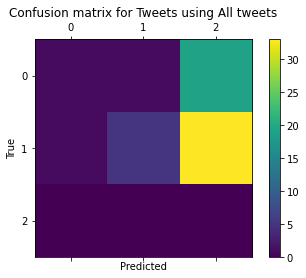

In [157]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', '2']
cm = confusion_matrix(df_questions_videos["binary_smarvote_answer"], df_questions_videos["cami_answers"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Tweets using All tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

not very optimistic, transcription is not great
--> and then we translate
add more videos, create context vectors